# Computation of velocity and acceleration 

- [ ] velocity
- [ ] acceleration


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd


#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt


import drifters.utils as ut
import pynsitu as pin

import dask.dataframe as dd
from dask.delayed import delayed

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.219:8787/status,
Dashboard: http://10.148.0.219:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.219:59714,Workers: 0
Dashboard: http://10.148.0.219:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
root_dir = "/home1/datawork/mdemol/GDP"
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")
#parquet_gps = os.path.join(root_dir, "gps_av_mean.parquet")

In [4]:
df_gps = dd.read_parquet(parquet_gps).persist()
#df_argos = dd.read_parquet(parquet_argos).persist()

## Visualisation 

In [5]:
df_gps.columns

Index(['time', 'lon', 'lat', 'id', 've', 'vn', 'x', 'y', 'ux', 'uy',
       'velocity', 'acc_x', 'acc_y', 'acc', 'ae', 'an', 'typebuoy', 'gap',
       'deploy_date', 'deploy_lat', 'deploy_lon', 'end_date', 'end_lat',
       'end_lon', 'drogue_lost_date', 'typedeath', 'lon360', 'err_lat',
       'err_lon', 'err_ve', 'err_vn', 'ae-ax', 'an-ay', 've-ux', 'vn-uy'],
      dtype='object')

In [6]:
df_gps.tail()

,time,lon,lat,id,ve,vn,x,y,ux,uy,...,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,ae-ax,an-ay,ve-ux,vn-uy
758,2020-04-06 03:00:00,-36.457001,33.035999,64500820,0.0721,-0.1042,1.945320e+06,-1.120695e+06,0.117460,-0.064094,...,0.0,323.542999,0.00085,0.00102,0.0369,0.0369,NaN,NaN,-0.045360,-0.040106
759,2020-04-06 03:00:00,-23.244511,44.751202,66893250,-0.0199,-0.1042,2.197322e+06,6.102793e+05,0.021092,-0.081204,...,0.0,336.755493,0.00085,0.00120,0.0369,0.0369,NaN,NaN,-0.040992,-0.022996
760,2020-04-06 03:00:00,128.103195,-41.000198,65707180,-0.0878,0.2636,4.869012e+06,-1.470081e+06,0.219573,0.136979,...,0.0,128.103195,0.00085,0.00113,0.0369,0.0369,NaN,NaN,-0.307373,0.126621
761,2020-04-06 03:00:00,42.227501,71.311203,67204880,0.0206,-0.2235,8.519843e+05,4.197143e+04,0.105703,-0.175020,...,0.0,42.227501,0.00085,0.00265,0.0369,0.0369,NaN,NaN,-0.085103,-0.048480
762,2020-04-06 03:00:00,-161.151428,-24.150450,67206560,0.0386,-0.0092,-1.746361e+06,-1.749561e+06,0.018975,-0.003921,...,0.0,198.848572,0.00080,0.00087,0.0056,0.0056,NaN,NaN,0.019625,-0.005279


## Trajectories

In [7]:
grp_id = df_gps.get_partition(0).groupby('id').get_group(22192).set_index('time').compute()

In [8]:
grp_id.head()

,lon,lat,id,ve,vn,x,y,ux,uy,velocity,...,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,ae-ax,an-ay,ve-ux,vn-uy
time,,,,,,,,,,,,,,,,,,,,,
2001-07-01 02:00:00,-94.795609,5.53791,22192,0.6460,-0.2900,0.000000,0.000000,NaN,NaN,NaN,...,3.0,265.204376,0.00052,0.00052,0.0100,0.0100,NaN,NaN,NaN,NaN
2001-07-01 03:00:00,-94.774597,5.52852,22192,0.6466,-0.2901,2328.165360,-1038.334652,0.649776,-0.294098,0.713234,...,3.0,265.225403,0.00052,0.00052,0.0134,0.0134,-0.000002,0.000004,-0.003176,0.003998
2001-07-01 04:00:00,-94.753387,5.51876,22192,0.6440,-0.2925,4678.387112,-2117.504284,0.656843,-0.308824,0.725820,...,3.0,265.246613,0.00065,0.00065,0.0135,0.0135,-0.000002,0.000001,-0.012843,0.016324
2001-07-01 05:00:00,-94.731918,5.50841,22192,0.6368,-0.2986,7057.436407,-3261.867565,0.660741,-0.317713,0.733158,...,3.0,265.268066,0.00059,0.00059,0.0122,0.0122,-0.000002,-0.000002,-0.023941,0.019113
2001-07-01 06:00:00,-94.710457,5.49807,22192,0.6296,-0.3047,9435.722447,-4405.037660,0.660764,-0.317528,0.733098,...,3.0,265.289551,0.00053,0.00053,0.0109,0.0109,-0.000002,-0.000002,-0.031164,0.012828


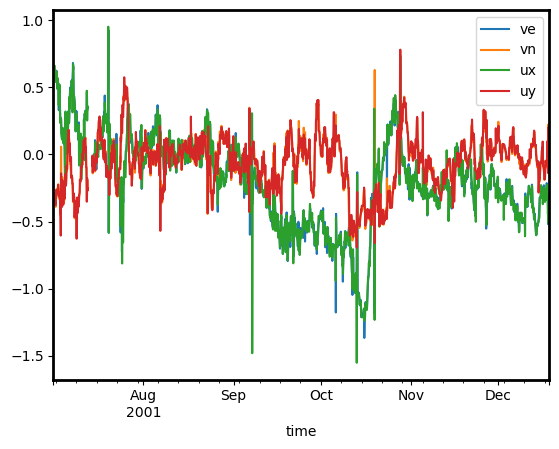

In [9]:
grp_id['ve'].plot(label = 've')
grp_id['vn'].plot(label = 'vn')
grp_id['ux'].plot(label = 'ux')
grp_id['uy'].plot(label = 'uy')
plt.legend()

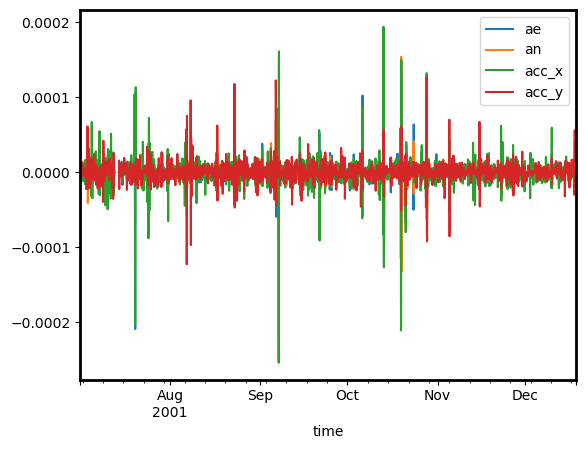

In [11]:
grp_id['ae'].plot(label = 'ae')
grp_id['an'].plot(label = 'an')
grp_id['acc_x'].plot(label = 'acc_x')
grp_id['acc_y'].plot(label = 'acc_y')
plt.legend()

## Diff derivation dependance on x,y

In [22]:
def deriv_dep2_x(df):
    xmin = (df["x"].min()).compute()
    xmax = (df["x"].max()).compute()
    df['ae-ax/ae']=df['ae-ax']/df['ae']
    df['an-ay/an']=df['an-ay']/df['an']
    df['ve-ux/ve']=df['ve-ux']/df['ve']
    df['vn-uy/vn']=df['vn-uy']/df['vn']
    #delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500) # 10min binning
    df['xcut'] = df["x"].map_partitions(pd.cut, xbins)
    mean = (df[['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']]
         .groupby(df.xcut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean['x'] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index('x')

    ds = (mean
          #.drop(columns=["year",])
          .to_xarray()
         )
    return ds

In [23]:
def deriv_dep2_y(df):
    xmin = (df["y"].min()).compute()
    xmax = (df["y"].max()).compute()
    df['ae-ax/ae']=df['ae-ax']/df['ae']
    df['an-ay/an']=df['an-ay']/df['an']
    df['ve-ux/ve']=df['ve-ux']/df['ve']
    df['vn-uy/vn']=df['vn-uy']/df['vn']
    #delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500) # 10min binning
    df['ycut'] = df["y"].map_partitions(pd.cut, xbins)
    mean = (df[['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']]
         .groupby(df.ycut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['ae-ax', 'an-ay', 've-ux', 'vn-uy','ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean['y'] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index('y')

    ds = (mean
          #.drop(columns=["year",])
          .to_xarray()
         )
    return ds

In [24]:
ds_x_gps = deriv_dep2_x(df_gps)
ds_y_gps = deriv_dep2_y(df_gps)

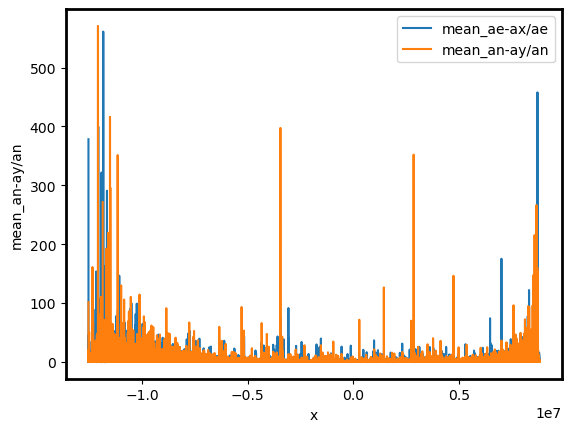

In [16]:
abs(ds_x_gps['mean_ae-ax/ae']).plot(label='mean_ae-ax/ae')
abs(ds_x_gps['mean_an-ay/an']).plot(label='mean_an-ay/an')
plt.legend()

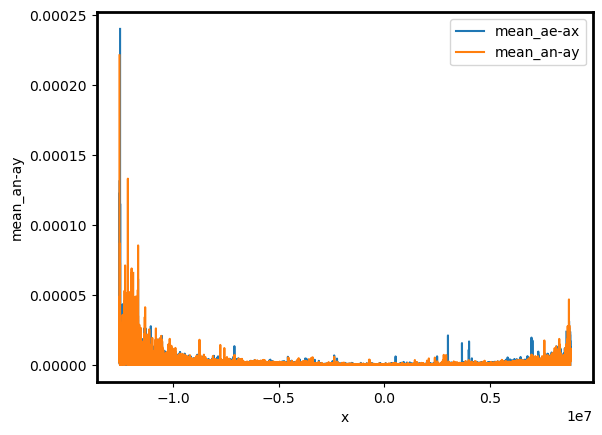

In [25]:
abs(ds_x_gps['mean_ae-ax']).plot(label='mean_ae-ax')
abs(ds_x_gps['mean_an-ay']).plot(label='mean_an-ay')
plt.legend()

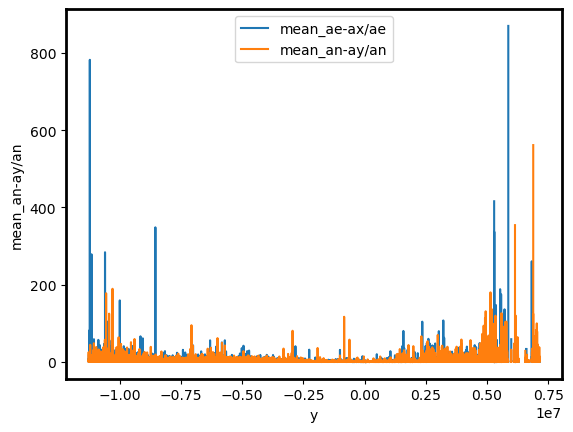

In [17]:
abs(ds_y_gps['mean_ae-ax/ae']).plot(label='mean_ae-ax/ae')
abs(ds_y_gps['mean_an-ay/an']).plot(label='mean_an-ay/an')
plt.legend()

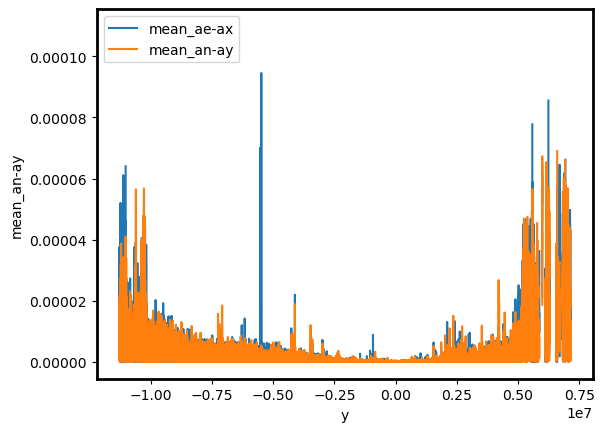

In [26]:
abs(ds_y_gps['mean_ae-ax']).plot(label='mean_ae-ax')
abs(ds_y_gps['mean_an-ay']).plot(label='mean_an-ay')
plt.legend()

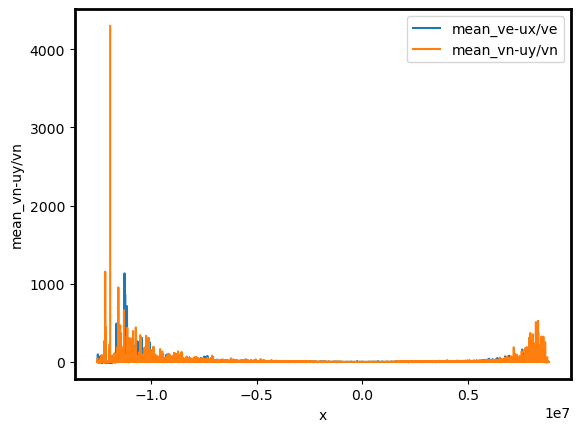

In [18]:
abs(ds_x_gps['mean_ve-ux/ve']).plot(label='mean_ve-ux/ve')
abs(ds_x_gps['mean_vn-uy/vn']).plot(label='mean_vn-uy/vn')
plt.legend()

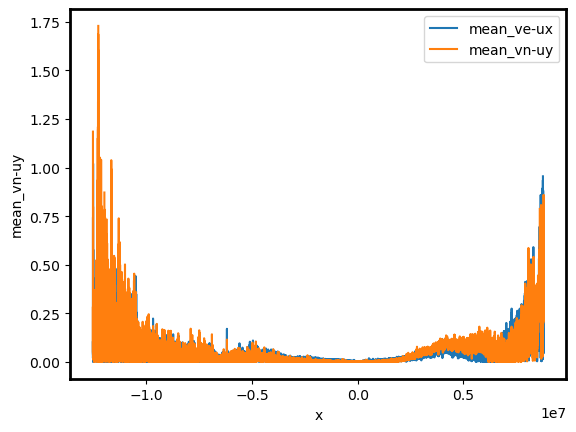

In [27]:
abs(ds_x_gps['mean_ve-ux']).plot(label='mean_ve-ux')
abs(ds_x_gps['mean_vn-uy']).plot(label='mean_vn-uy')
plt.legend()

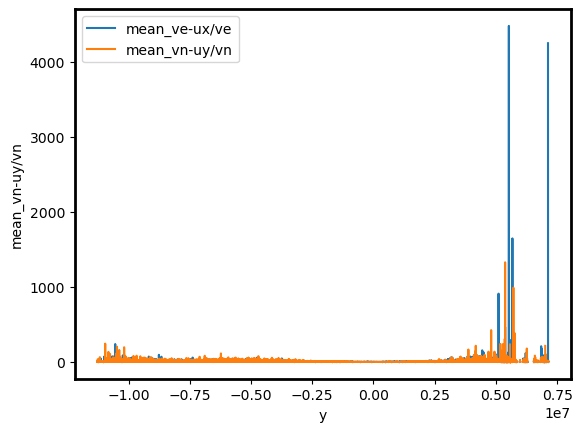

In [21]:
abs(ds_y_gps['mean_ve-ux/ve']).plot(label='mean_ve-ux/ve')
abs(ds_y_gps['mean_vn-uy/vn']).plot(label='mean_vn-uy/vn')
plt.legend()

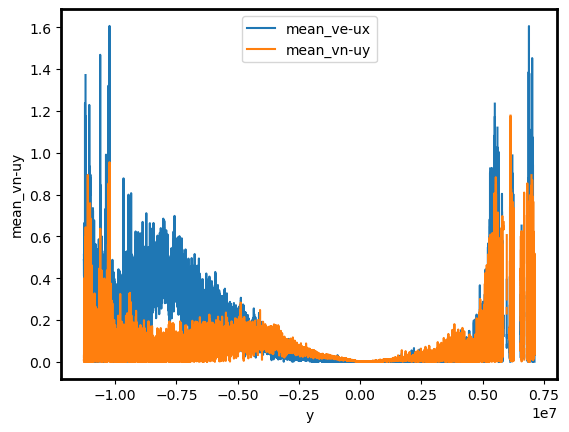

In [28]:
abs(ds_y_gps['mean_ve-ux']).plot(label='mean_ve-ux')
abs(ds_y_gps['mean_vn-uy']).plot(label='mean_vn-uy')
plt.legend()

## Diff derivation dependance on the gap

In [22]:
def deriv_dep2_gap(df):
    gap_min = (df["gap"].min()).compute()
    gap_max = (df["gap"].max()).compute()
    df['ae-ax/ae']=df['ae-ax']/df['ae']
    df['an-ay/an']=df['an-ay']/df['an']
    df['ve-ux/ve']=df['ve-ux']/df['ve']
    df['vn-uy/vn']=df['vn-uy']/df['vn']
    #delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    gap_bins = np.arange(gap_min, gap_max, 1800) # 10min binning
    df['gap_cut'] = df["gap"].map_partitions(pd.cut, gap_bins)
    mean_gap = (df[['ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']]
         .groupby(df.gap_cut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean_gap['gap'] = mean_gap.index.to_series().apply(lambda d: d.mid)
    mean_gap = mean_gap.set_index('gap')

    ds = (mean_gap
          #.drop(columns=["year",])
          .to_xarray()
         )
    ds['gap']=ds['gap']/3600 # gap in hours
    return ds

In [37]:
ds_gap_gps = deriv_dep2_gap(df_gps)

In [38]:
ds_gap_gps

<xarray.Dataset>
Dimensions:        (gap: 23)
Coordinates:
  * gap            (gap) float64 0.25 0.75 1.25 1.75 ... 9.75 10.25 10.75 11.25
Data variables:
    mean_ae-ax/ae  (gap) float64 0.007464 0.0006882 -7.729e-05 ... 0.1279 0.311
    mean_an-ay/an  (gap) float64 0.01503 0.0001313 -1.043e-05 ... 0.6388 -0.7925
    mean_ve-ux/ve  (gap) float64 0.001666 0.004553 7.786e-06 ... 0.02743 -0.1862
    mean_vn-uy/vn  (gap) float64 0.003165 0.001688 6.608e-05 ... 0.5359 -0.4002

In [6]:
abs(ds_gap_gps['mean_ae-ax/ae']).plot(label='mean_ae-ax/ae')
abs(ds_gap_gps['mean_an-ay/an']).plot(label='mean_an-ay/an')
plt.legend()

NameError: name 'ds_gap_gps' is not defined

In [7]:
abs(ds_gap_gps['mean_ve-ux/ve']).plot(label='mean_ve-ux/ve')
abs(ds_gap_gps['mean_vn-uy/vn']).plot(label='mean_vn-uy/vn')
plt.legend()

NameError: name 'ds_gap_gps' is not defined

## Diff derivation dependance on the gap

In [ ]:
df_out = df_gps[['ae-ax/ae', 'an-ay/an', 've-ux/ve', 'vn-uy/vn']].compute()

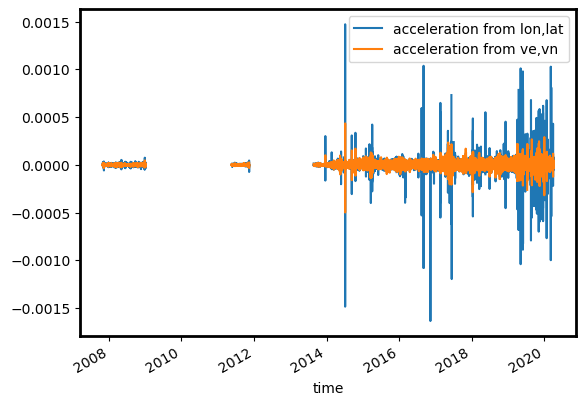

In [12]:
df_gps['acc_x'].plot(label='acceleration from lon,lat')
df_gps['ae'].plot(label='acceleration from ve,vn')
plt.legend()

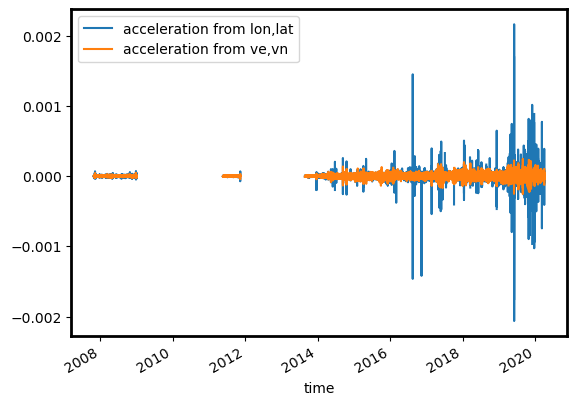

In [13]:
df_out['acc_y'].plot(label='acceleration from lon,lat')
df_out['an'].plot(label='acceleration from ve,vn')
plt.legend()

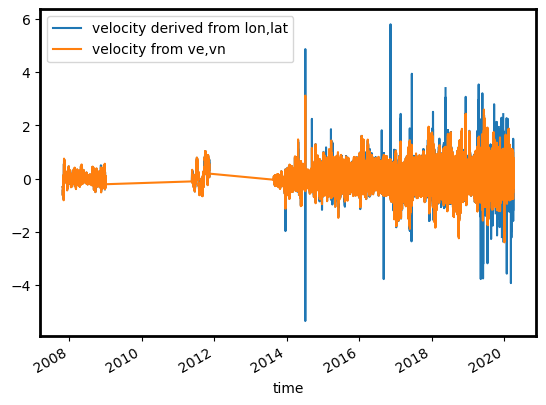

In [14]:
df_out['ux'].plot(label='velocity derived from lon,lat')
df_out['ve'].plot(label='velocity from ve,vn')
plt.legend()

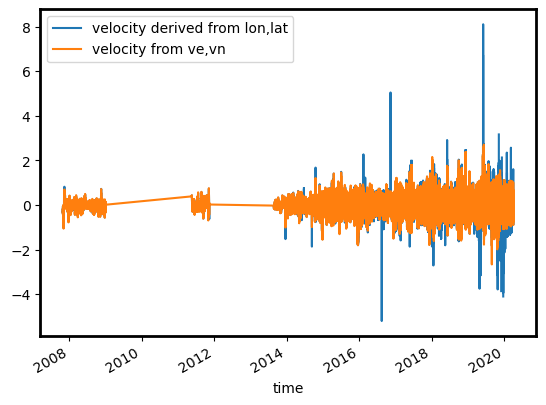

In [15]:
df_out['uy'].plot(label='velocity derived from lon,lat')
df_out['vn'].plot(label='velocity from ve,vn')
plt.legend()

In [29]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
